# 4. Aqarios Luna Platform and FlexQAOA

### Overview

In this notebook, we will touch upon the product of Aqarios GmbH, which is the **Luna Platform**

Luna is comprised of three pillars, namely
1. **LunaQ**: Universal access to a plethora of Quantum Backends, including IonQ, IQM, Rigetti, and D-Wave.
2. **LunaSolve**: A collection of quantum, classical, and hybrid algorithms for solving combinatorial optimization problems
3. **LunaBench**: A benchmarking framework for comparing algorithms and encodings on optimization problem datasets.

Luna features one of our algorithmic developments: _FlexQAOA_, a QAOA implementation that includes the automatic QAOA design features we have developed today, amongst others as we will learn later.
Furthermore, FlexQAOA features a specialized simulator that uses a feasible-subspace constrained Quantum Algorithm by only simulating the necessary statevector entries. This allows simulating drastically larger optimization problems as are possible without this extension.

### Connecting to Luna

Under the following link, you need to register for the Luna Platform: [app.aqarios.com](https://app.aqarios.com). Please enter "QCE Tutorial" when asked for what you will use Luna.

After the registration has been completed, you can copy the API Key from the Platform Dashbord and store it in the `$PROJECT_ROOT/.env` file.
```sh
echo 'LUNA_API_KEY="<YOUR_API_KEY>"' > .env
```
Then you should be able to access Luna.
> **Note:** FlexQAOA is currently a paid feature in the platform. You will have access to the solver throughout Quantum Week; afterwards, this access will be retracted.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rich
import random

from luna_quantum import algorithms, LunaSolve, Model
from luna_quantum.solve.parameters.algorithms.base_params import (
    BasicQAOAParams,
    RandomQAOAParams,
    LinearQAOAParams,
    ScipyOptimizerParams,
)
from luna_quantum.solve.parameters.algorithms.quantum_gate.flex_qaoa import (
    InterpolateOptimizerParams,
)

from luna_quantum.transformations import PassManager

# Classical optimization
from scipy.optimize import minimize

# Import model data
from model.data import ConventionCenter, Schedule, SessionChair
from model.visualization import (
    plot_floor_plan,
    solution_to_assignment,
)
from model.model import optimization_model

# Import utils (from last notebook)
from utils.sampling import cost_function, sample
from utils.qaoa import qaoa_circ_adv
from utils import pretty

# from utils.transformations import qubo_pipeline

%load_ext dotenv
%dotenv

if os.environ.get("LUNA_API_KEY") is not None:
    print("✅ API Key found")
else:
    print("❌ API Key not found!")

✅ API Key found


In [2]:
# Try connecting to Luna
try:
    LunaSolve()
    print("✅ Successfully connected to Luna.")
except Exception as e:
    print("❌ Connection to Luna failed.")
    raise e

✅ Successfully connected to Luna.


## The Session Chair Assignment Problem, Again

We use the same problem as investageted in the last notebooks here as well.

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

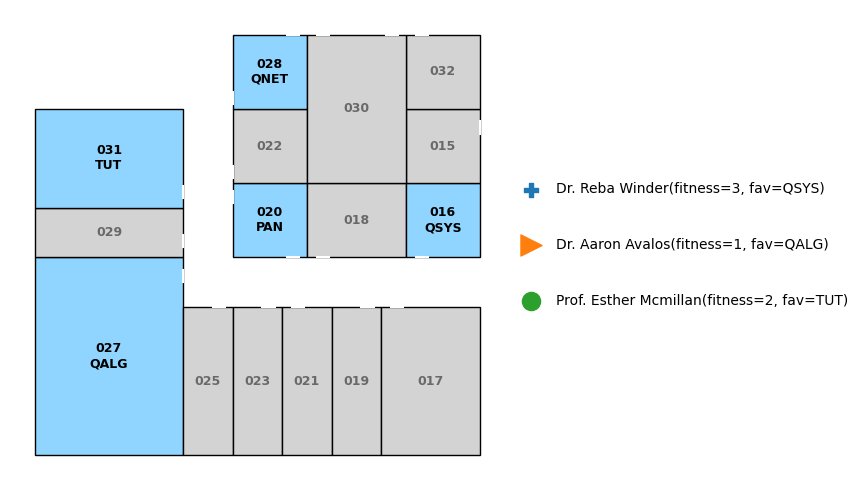

In [3]:
center = ConventionCenter.generate()
schedule = Schedule.random(5, center, seed=5)
chairs = SessionChair.random_chairs(3, schedule=schedule, seed=2)

satisfaction = 2

plot_floor_plan(center, schedule=schedule, chairs=chairs)

In [15]:
x, model = optimization_model(center, schedule, chairs, satisfaction=satisfaction)
# model.add_variable("y")

## Basic LunaSolve usage
In the `luna_quantum.algorithms` module, you can find a list of the platform's available solvers. Currently, not all solvers can solve all models; most solvers and heuristics are specialized for Quadratic Unconstrained Binary Optimization Problems. In the upcoming months, we will roll out the transformations internally, making general transformations to fit formats a feature for all available solvers.

One of the solvers that is capable of solving constrained optimization problems is **SCIP** (Solving Constrained Integer Problems). This is a classical branch-and-cut solver that mathematically proves that the found solution is the optimum one, when it converges. Simply instantiate an solver object (other solvers may have parameters) and run the algorithm with the model attached.

In [16]:
scip = algorithms.SCIP()
sol = scip.run(model).result()

Output()

Output()

2025-08-27 12:07:47 INFO     {"model_id":"68908af71665c3a889803029","solver_name":"SCIP","provider":"zib","paramete
                             rs":{},"name":null}

Output()

Output()

2025-08-27 12:07:49 ERROR    Solve job failed with the error 'Model 68908af71665c3a889803029, OptFormat.AQ_MODEL   
                             not found'.

In [17]:
# Just a single solution here
pretty(sol)

AttributeError: 'NoneType' object has no attribute 'obj_values'

In [11]:
best = sol.best()
assignment = solution_to_assignment(best, chairs)
plot_floor_plan(center, schedule=schedule, chairs=chairs, assignment=assignment)

AttributeError: 'NoneType' object has no attribute 'best'

## FlexQAOA

As already teasered, FlexQAOA helps

In [12]:
fqaoa = algorithms.FlexQAOA(reps=3)
rich.print(fqaoa)

FlexQAOA(
    shots=1024,
    reps=3,
    pipeline=PipelineParams(
        indicator_function=IndicatorFunctionParams(penalty=None, penalty_scaling=2),
        one_hot=OneHotParams(),
        quadratic_penalty=QuadraticPenaltyParams(penalty=None)
    ),
    optimizer=ScipyOptimizerParams(
        method='cobyla',
        tol=None,
        bounds=None,
        jac=None,
        hess=None,
        maxiter=100,
        options={}
    ),
    qaoa_config=AdvancedConfig(
        mixer=XYMixer(types=['even', 'odd', 'last']),
        parallel_indicators=True,
        discard_slack=False,
        infeas_penalty=None
    ),
    initial_params=LinearQAOAParams(delta_beta=0.5, delta_gamma=0.5)
)

In [13]:
sol = fqaoa.run(model).result()
pretty(sol)

Output()

Output()

2025-08-27 12:06:30 INFO     {"model_id":"68aed88da5d1d9519f99fac6","solver_name":"FlexQAOA","provider":"aqarios","
                             parameters":{"shots":1024,"reps":3,"pipeline":{"indicator_function":{"penalty":null,"p
                             enalty_scaling":2},"one_hot":{},"quadratic_penalty":{"penalty":null}},"optimizer":{"me
                             thod":"cobyla","tol":null,"bounds":null,"jac":null,"hess":null,"maxiter":100,"options"
                             :{}},"qaoa_config":{"mixer":{"types":["even","odd","last"]},"parallel_indicators":true
                             ,"discard_slack":false,"infeas_penalty":null},"initial_params":{"delta_beta":0.5,"delt
                             a_gamma":0.5}},"name":null}

Output()

Output()

2025-08-27 12:06:32 INFO     Sleeping for 5.0 seconds. Waiting and checking a function in a loop.

Output()

x_016_0,x_016_1,x_016_2,x_028_0,x_028_1,x_028_2,x_020_0,x_020_1,x_020_2,x_031_0,x_031_1,...
1,0,0,0,1,0,0,0,1,0,0,
1,0,0,0,1,0,0,0,1,0,0,
1,0,0,0,1,0,1,0,0,0,0,
1,0,0,0,1,0,1,0,0,0,0,
1,0,0,1,0,0,0,0,1,0,0,
1,0,0,1,0,0,0,0,1,0,0,
0,1,0,0,0,1,1,0,0,1,0,
0,0,1,0,1,0,1,0,0,1,0,
0,1,0,0,0,1,1,0,0,1,0,
0,0,1,0,1,0,1,0,0,1,0,


In [ ]:
best = sol.best()
assignment = solution_to_assignment(best, chairs)
plot_floor_plan(center, schedule=schedule, chairs=chairs, assignment=assignment)

Disable the XY-Mixers and use Quadratic Penalties instead. This can be simply done by disabling the `pipeline.one_hot` setting.

In [ ]:
fqaoa = algorithms.FlexQAOA(reps=3)
fqaoa.pipeline.one_hot = None
sol2 = fqaoa.run(model).result()

pretty(sol2)

In [ ]:
fqaoa = algorithms.FlexQAOA(reps=1, optimizer=InterpolateOptimizerParams(reps_end=5))
sol3 = fqaoa.run(model).result()

pretty(sol3)

**Comparing The Approaches...**

...clearly shows that the XY-Mixer one delivers drastically better solutions. This is with filtering out all infeasible samples in the penaltiy one.

In [ ]:
bins = np.linspace(0, 100, 50)
# plt.hist(sol.obj_values, bins=bins, weights=sol.counts)
plt.hist(
    sol3.obj_values,
    bins=bins,
    weights=sol3.counts,
    alpha=0.6,
    label="FlexQAOA(XY, interp)",
)
plt.axvline(x=sol3.expectation_value(), linestyle="dashed")
plt.hist(sol.obj_values, bins=bins, weights=sol.counts, alpha=0.6, label="FlexQAOA(XY)")
plt.axvline(x=sol.expectation_value(), color="C1", linestyle="dashed")
plt.hist(
    sol2.raw_energies,
    bins=bins,
    weights=sol2.counts,
    alpha=0.6,
    label="FlexQAOA(no XY)",
)
plt.axvline(x=sol2.expectation_value(), color="C2", linestyle="dashed")
plt.legend();

## We Can Go Larger

As already teased in the overview, focusing on the constrained subspace allows us to increase the problem size while keeping computational demand low.

FlexQAOA's simulator in Luna is currently limited to an equivalent of $2^{18}$ qubits state vector simulation due to CPU simulation only. In the following, we increase the problem to 11 rooms and 3 session chairs.
With the penalty formalism, this requires 33 qubits in simulation. However, FlexQAOA simulates a state vector with $3^{11} \approx 177\ 000 < 2^{18}$, making this problem accessible to simulation.

In [ ]:
center = ConventionCenter.generate()
schedule = Schedule.random(11, center, seed=5)
chairs = SessionChair.random_chairs(3, schedule=schedule, seed=2)

satisfaction = 2

plot_floor_plan(center, schedule=schedule, chairs=chairs)

In [ ]:
x, model = optimization_model(center, schedule, chairs, satisfaction=satisfaction)

In [ ]:
fqaoa = algorithms.FlexQAOA(reps=3)
# You can try disabling XY-Mixers, but this will eventually fail
# fqaoa.pipeline.one_hot = None
sol = fqaoa.run(model).result()
pretty(sol)

In [ ]:
best = sol.best()
assignment = solution_to_assignment(best, chairs)
plot_floor_plan(center, schedule=schedule, chairs=chairs, assignment=assignment)

In [ ]:
sol_scip = scip.run(model).result()
pretty(sol_scip)

# Preparation for Bechmarking

In our next step, we will perform comprehensive benchmarking. To this end, it is a great idea to wrap our code into the same API as the `luna_quantum` module has.

This class is responsible for algorithm parameters, initial variational parameters and optimizer parameters.

In [ ]:
class MyQAOA:
    """Wraps our QAOA implementation in Luna Quantum API."""

    def __init__(
        self,
        pass_manager: PassManager,
        reps: int = 1,
        shots: int = 1024,
        initial_params: LinearQAOAParams
        | BasicQAOAParams
        | RandomQAOAParams
        | None = None,
        optimizer: ScipyOptimizerParams | None = None,
    ):
        self.pass_manager = pass_manager
        self.reps = reps
        self.shots = shots
        self.params = initial_params or LinearQAOAParams(
            delta_beta=0.5, delta_gamma=0.5
        )
        self.optimizer = optimizer or ScipyOptimizerParams()

        self.qc = None

    def _get_initial(self):
        """Generates initial QAOA circuit params from input."""
        if isinstance(self.params, LinearQAOAParams):
            delta = 1 / self.reps
            betas = [
                self.params.delta_beta * (1 - delta / 2 - delta * i)
                for i in range(self.reps)
            ]
            gammas = [
                self.params.delta_gamma * (delta / 2 + delta * i)
                for i in range(self.reps)
            ]
            return betas + gammas
        elif isinstance(self.params, BasicQAOAParams):
            return self.params.betas + self.params.gammas
        else:
            random.seed(self.params.seed)
            betas = [random.uniform(*self.params.beta_range) for _ in range(self.reps)]
            gammas = [
                random.uniform(*self.params.gamma_range) for _ in range(self.reps)
            ]
            return betas + gammas

    def _optimizer_kwargs(self):
        """Generates a scipy minimize compliant kwargs dict from input."""
        kwargs = self.optimizer.model_dump(exclude_none=True)
        kwargs["options"]["maxiter"] = kwargs.pop("maxiter")
        return kwargs

    @property
    def circuit(self):
        """Store and receive the quantum circuit."""
        if self.qc is None:
            raise RuntimeError("Make sure to run algorithm before accessing circuit")
        return self.qc

    def run(self, model: Model):
        """Runs the QAOA."""
        x0 = self._get_initial()
        optimizer_kwargs = self._optimizer_kwargs()

        ##TASK>
        ir = self.pass_manager.run(model)
        qc = qaoa_circ_adv(ir, self.reps)

        log = []

        res = minimize(
            cost_function,
            args=(ir.model, qc, log, self.shots),
            x0=x0,
            **optimizer_kwargs,
        )

        sol = sample(ir.model, qc, res.x, self.shots)
        res = self.pass_manager.backwards(sol, ir)
        ##<TASKEND

        # Cache the quantum circuit
        self.qc = qc

        # Result wrapper to align with the job pattern
        class ResultWrapper:
            def result(self):
                return res

        return ResultWrapper()

---

## 🎉 Congratulations!

You've successfully completed this tutorial! We hope you found it helpful and informative.

### 📖 References & Further Reading
This tutorial was built upon the following resources:

- Luna Docs [[Link]](https://docs.aqarios.com)
- D. Bucher et al., 2025: "Efficient QAOA Architecture for Solving Multi-Constrained Optimization Problems" [[Paper]](https://arxiv.org/abs/2506.03115)

### 🚀 Coming Up Next

In the [next tutorial](05_Benchmarking.ipynb), we will benchmark our implementation with FlexQAOA to quantify the performance improvement of advanced architectures.

---
## 💡 Ready to dive deeper?

Explore more tutorials, documentation, and resources to accelerate your journey

<img src="https://docs.aqarios.com/assets/aqarios.png#only-light" width="400px" alt="Aqarios Logo" />

[![Website](https://img.shields.io/badge/🌐_Website-Visit_Aqarios.com-blue?style=for-the-badge)](https://www.aqarios.com)
[![Documentation](https://img.shields.io/badge/📚_Documentation-Explore_Docs-green?style=for-the-badge)](https://docs.aqarios.com)
[![LinkedIn](https://img.shields.io/badge/🤝_LinkedIn-Connect_With_Us-0077B5?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/company/aqarios-gmbh/)


**What's Next?**

- **Explore our documentation** for advanced features and best practices
- **Join our community** on LinkedIn for updates and discussions  
- **Check out more tutorials** to expand your skills

### 💬 Need Help?

Have questions or feedback about this tutorial? We'd love to hear from you! Connect with us through any of the links above.

---

<div align="center">
<small>

Tutorial provided by Aqarios GmbH | © 2025 Aqarios GmbH | Made with ❤️ for developers

</small>
</div>